In [1]:
from torchdiffeq import odeint_adjoint as odeint
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# device = torch.device("cuda")
device = torch.device("cpu")

t = torch.linspace(0, 5, 1000)
print(t)

tensor([0.0000, 0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350, 0.0400,
        0.0450, 0.0501, 0.0551, 0.0601, 0.0651, 0.0701, 0.0751, 0.0801, 0.0851,
        0.0901, 0.0951, 0.1001, 0.1051, 0.1101, 0.1151, 0.1201, 0.1251, 0.1301,
        0.1351, 0.1401, 0.1451, 0.1502, 0.1552, 0.1602, 0.1652, 0.1702, 0.1752,
        0.1802, 0.1852, 0.1902, 0.1952, 0.2002, 0.2052, 0.2102, 0.2152, 0.2202,
        0.2252, 0.2302, 0.2352, 0.2402, 0.2452, 0.2503, 0.2553, 0.2603, 0.2653,
        0.2703, 0.2753, 0.2803, 0.2853, 0.2903, 0.2953, 0.3003, 0.3053, 0.3103,
        0.3153, 0.3203, 0.3253, 0.3303, 0.3353, 0.3403, 0.3453, 0.3504, 0.3554,
        0.3604, 0.3654, 0.3704, 0.3754, 0.3804, 0.3854, 0.3904, 0.3954, 0.4004,
        0.4054, 0.4104, 0.4154, 0.4204, 0.4254, 0.4304, 0.4354, 0.4404, 0.4454,
        0.4505, 0.4555, 0.4605, 0.4655, 0.4705, 0.4755, 0.4805, 0.4855, 0.4905,
        0.4955, 0.5005, 0.5055, 0.5105, 0.5155, 0.5205, 0.5255, 0.5305, 0.5355,
        0.5405, 0.5455, 0.5506, 0.5556, 

In [2]:
max_angular_displacement = 5
max_angular_velocity = 30
vector_points = 20

def visualize_one(pred_y, odefunc, itr):
    fig = plt.figure(figsize=(8, 8), facecolor='white')

    angular_displacement = fig.add_subplot(221, frameon=False)
    angular_velocity = fig.add_subplot(222, frameon=False)
    phase_space = fig.add_subplot(223, frameon=False)
    vector_field = fig.add_subplot(224, frameon=False)

    angular_displacement.cla()
    angular_displacement.set_title('Angular Displacement')
    angular_displacement.set_xlabel('t')
    angular_displacement.set_ylabel('angular displacement(rad)')
    angular_displacement.plot(t.detach().numpy(), pred_y.detach().numpy()[:, 0, 0], color='blue', linestyle='--', label='predicted value')
    angular_displacement.set_xlim(t.detach().min(), t.detach().max())
    angular_displacement.set_ylim(-max_angular_displacement, max_angular_displacement)
    angular_displacement.legend(loc="best")

    angular_velocity.cla()
    angular_velocity.set_title('Angular Velocity')
    angular_velocity.set_xlabel('t')
    angular_velocity.set_ylabel('angular velocity(rad/s)')
    angular_velocity.plot(t.detach().numpy(), pred_y.detach().numpy()[:, 0, 1], color='orange', linestyle='--', label='predicted value')
    angular_velocity.set_xlim(t.detach().min(), t.detach().max())
    angular_velocity.set_ylim(-max_angular_velocity, max_angular_velocity)
    angular_velocity.legend(loc="best")

    phase_space.cla()
    phase_space.set_title('Phase Space')
    phase_space.set_xlabel('angular displacement(rad)')
    phase_space.set_ylabel('angular velocity(rad/s)')
    phase_space.plot(pred_y.detach().numpy()[:, 0, 0], pred_y.detach().numpy()[:, 0, 1], color='skyblue', linestyle='--', label='predicted path')
    phase_space.set_xlim(-max_angular_displacement, max_angular_displacement)
    phase_space.set_ylim(-max_angular_velocity, max_angular_velocity)
    phase_space.legend(loc="best")

    vector_field.cla()
    vector_field.set_title('Learned Vector Field')
    vector_field.set_xlabel('angular displacement(rad)')
    vector_field.set_ylabel('angular velocity(rad/s)')

    y, x = np.mgrid[-max_angular_velocity:max_angular_velocity:complex(vector_points), 
                    -max_angular_displacement:max_angular_displacement:complex(vector_points)]
    velocity = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(vector_points * vector_points, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2).reshape(-1, 1)
    velocity = (velocity / mag)
    velocity = velocity.reshape(vector_points, vector_points, 2)

    vector_field.streamplot(x, y, velocity[:, :, 0], velocity[:, :, 1], color="black")
    vector_field.set_xlim(-max_angular_displacement, max_angular_displacement)
    vector_field.set_ylim(-max_angular_velocity, max_angular_velocity)

    fig.tight_layout()
    plt.savefig('png/{:03d}.png'.format(itr))
    # plt.draw()
    # plt.pause(0.001)
    
class TargetFunction(nn.Module):
    def __init__(self, omega_x, omega_y):
        super().__init__()
        # Define the matrix that represents elliptic motion in the x, y plane
        self.elliptic_matrix = torch.tensor([[0, -omega_y], [omega_x, 0]]).to(device)

    def forward(self, t, x):
        # Elliptical motion in the x, y plane
        return torch.mm(x, self.elliptic_matrix)

# Example angular velocities for x and y axes
omega_x = 0.2  # Angular velocity in the x-direction
omega_y = 10  # Angular velocity in the y-direction (different to create ellipse)

# Create the TargetFunction instance for elliptic motion
elliptic_function = TargetFunction(omega_x, omega_y).to(device)

/var/folders/59/kqhf430j1vd2lv6s6h1ns23m0000gn/T/ipykernel_6440/2664026094.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('model_state_d

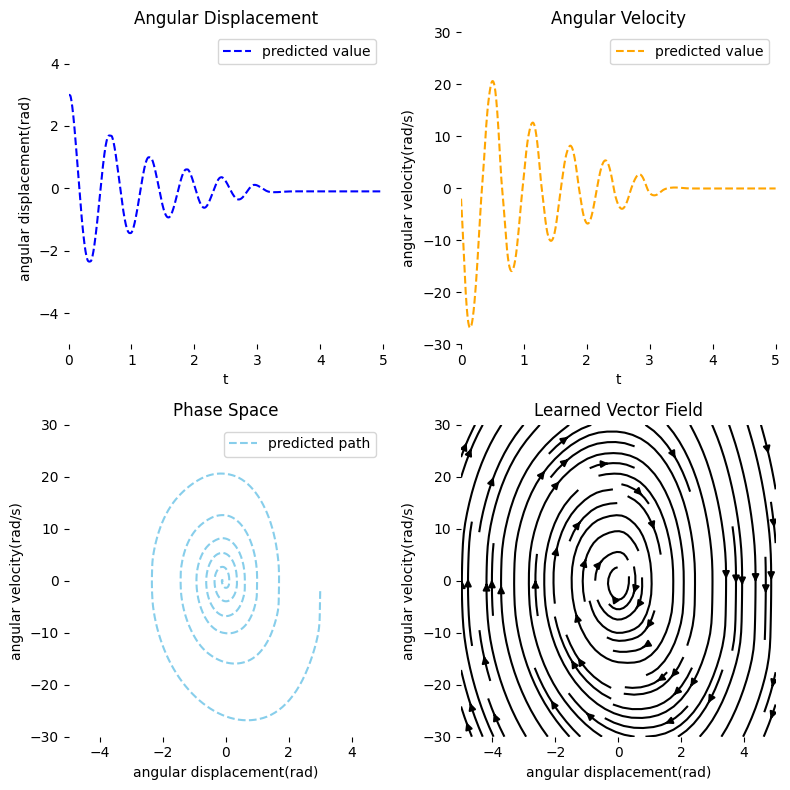

In [12]:
class PredictFunction(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, t, x):
        return self.net(x)

net = PredictFunction().to(device)

class DivergentFunction(nn.Module):
    def forward(self, t, x):
        return x*2

divergent = DivergentFunction().to(device)

# 가중치 로드
net.load_state_dict(torch.load('model_state_dict.pt'))

init_state = torch.Tensor([[3, -2]])

pred_dxdt = odeint(net, init_state, t)

visualize_one(pred_dxdt, net, 1)
# visualize_one(pred_dxdt, divergent, 1)